In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

In [2]:
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "jz_skill_patterns.jsonl"

In [3]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [4]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

In [5]:
import pandas as pd

data = pd.read_csv('data.csv')
data.head(10)

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit
5,"SummarySolution-oriented, results-driven strat...",\n\nResponsibilitiesLead and provide day-to-da...,No Fit
6,SummaryA position in a company that will utili...,"Senior Salesforce Software Engineer, Salesforc...",No Fit
7,SummaryTo participate as a team member in a dy...,***W2 ONLY** \nSoftware Engineer (12-month con...,No Fit
8,SummaryMore than ten years of progressive expe...,Calling all innovators find your future at Fi...,No Fit
9,SummaryCERTIFIED SOFTWARE DEVELOPMENT PROFESSI...,Who We AreWere reinventing the egg protein bus...,No Fit


In [6]:
import pandas as pd
from transformers import pipeline
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import numpy as np
from tqdm import tqdm
import math

tqdm.pandas()

# Load the processed data
data = pd.read_csv('data.csv')

# Initialize the summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Initialize the sentence transformer model
model = SentenceTransformer("jinaai/jina-embeddings-v2-small-en", trust_remote_code=True)
model.max_seq_length = 1024

# Function to calculate similarity
def calculate_similarity(job_description, resume):
    job_posting_input_length = len(summarizer.tokenizer(job_description)['input_ids'])
    if job_posting_input_length > 1024:
        job_description = job_description[:1024]
        print("Job posting too long")

    resume_input_length = len(summarizer.tokenizer(resume)['input_ids'])
    if resume_input_length > 1024:
        resume = resume[:1024]
        print("Resume too long")

    job_posting_skills = unique_skills(get_skills(job_description))
    job_posting_summary = summarizer(job_description, max_length=math.floor(0.9 * job_posting_input_length), min_length=math.floor(0.5 * job_posting_input_length), do_sample=False)[0]['summary_text']
    job_posting_sentences = sent_tokenize(job_posting_summary)
    job_posting_sentences = job_posting_sentences + job_posting_skills
    print(job_posting_sentences)

    resume_skills = unique_skills(get_skills(resume))
    resume_summary = summarizer(resume, max_length=math.floor(0.9 * resume_input_length), min_length=math.floor(0.5 * resume_input_length), do_sample=False)[0]['summary_text']
    resume_sentences = sent_tokenize(resume_summary)
    resume_sentences = resume_sentences + resume_skills
    print(resume_sentences)

    similarities = {}

    for job_posting_sentence in job_posting_sentences:
        max_similarity = float('-inf')
        for resume_sentence in resume_sentences:
            sentences = [job_posting_sentence, resume_sentence]
            embeddings = model.encode(sentences)
            similarity = cos_sim(embeddings[0], embeddings[1])

            if similarity > max_similarity:
                similarities[job_posting_sentence] = np.squeeze(similarity[0].numpy())

    overall_similarity = sum(similarities.values())
    return overall_similarity

# Apply the function to each row in the DataFrame
data['similarity'] = data.progress_apply(lambda row: calculate_similarity(row['job_description_text'], row['resume_text']), axis=1)

# Save the updated DataFrame to a new CSV file
data.to_csv('resumes_job_postings_with_similarities.csv', index=False)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/70.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py:   0%|          | 0.00/97.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/65.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  0%|          | 0/6241 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1412 > 1024). Running this sequence through the model will result in indexing errors


Resume too long


Your max_length is set to 1270, but your input_length is only 202. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=101)


['Net2Source Inc. is an award-winning total workforce solutions company recognized by Staffing Industry Analysts for our accelerated growth of 300% in the last 3 years.', 'We help clients with new skilling, talent strategy, leadership development, employee experience, transformational change management and beyond.', 'At Net2Source, we believe everyone has an opportunity to lead.', 'We want you to fit inwith an inclusive culture, focus on work-life fit and well-being, and a supportive, connected environment.', 'We believe that no one should be discriminated against because of their differences, such as age, disability, ethnicity, gender, gender identity and expression, religion or sexual orientation.', 'All employment decisions shall be made without regard to age, race, creed, color, religion, sex, national origin, ancestry, disability status, veteran status, sexual orientation,.', 'gender identity or expression, genetic information, marital status, citizenship status or any other basis

  0%|          | 2/6241 [02:46<144:08:43, 83.17s/it]

Resume too long


Your max_length is set to 1177, but your input_length is only 199. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=99)


['Nelson Engineering, a Salas OBrien Company, is an employee-owned engineering and professional services firm focused on achieving impact for our clients, our team, and the world.', 'You will acquire time management, communication, and CAD drafting skills, as well as have the chance to apply engineering concepts.', 'You are currently enrolled in an Electrical Engineering program at a four-year ABET university or college with preferred targeted graduation date within 1 year (preferred) You are able to work part-time, with a minimum of 12 hours and a maximum of 18 hours per week.', 'You must have reliable transportation.', 'You have experience with Microsoft Office programs (including Word, Excel, and Outlook)You are well organized and can effectively manage work and academic responsibilities simultaneously.Verification of US Citizenship required upon hire.Location: Merritt Island, FL \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0Equal Opportunity Employment Statement (EOC) prohibits discrimina

  0%|          | 2/6241 [04:50<251:19:29, 145.02s/it]


KeyboardInterrupt: 

In [8]:
min_value = data['similarity'].min()
max_value = data['similarity'].max()
data['similarity'] = (data['similarity'] - min_value) / (max_value - min_value)
data['similarity']

0    1.000000
1    1.000000
2    1.000000
3    1.000000
4    0.430840
5    0.207519
6    0.000000
Name: similarity, dtype: float64

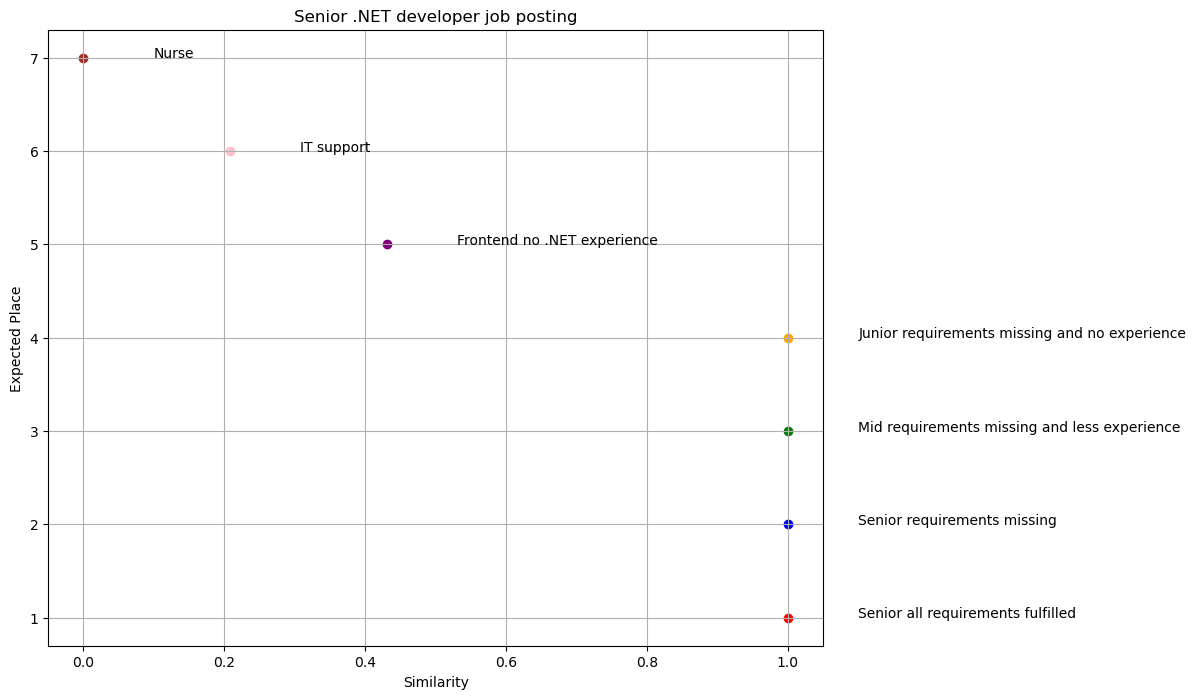

In [18]:
# Adding label column
data['label'] = ['Senior all requirements fulfilled', 
                 'Senior requirements missing', 
                 'Mid requirements missing and less experience', 
                 'Junior requirements missing and no experience', 
                 'Frontend no .NET experience', 
                 'IT support', 
                 'Nurse']

# Plotting
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown']
for label, color in zip(data['label'].unique(), colors):
    plt.scatter(data[data['label'] == label]['similarity'], 
                data[data['label'] == label]['expected_place'], 
                color=color, 
                alpha=1)
    # Add labels next to the points
    for index, row in data[data['label'] == label].iterrows():
        plt.text(row['similarity'] + 0.1, row['expected_place'], row['label'], fontsize=10, color='black')

plt.title('Senior .NET developer job posting')
plt.xlabel('Similarity')
plt.ylabel('Expected Place')
plt.grid(True)
plt.show()

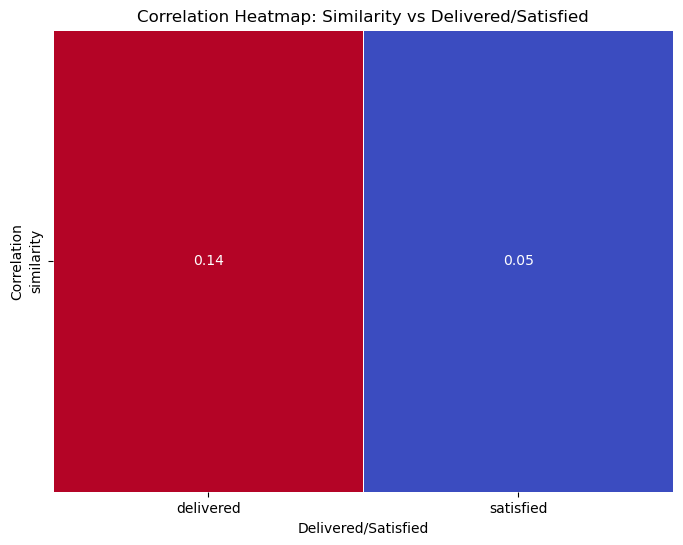

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the dataset
data = pd.read_csv('filtered_actions_with_similarities.csv')

# Compute the correlation matrix between similarity, delivered, and satisfied
correlation_matrix = data[['similarity', 'delivered', 'satisfied']].corr()

# Extract the correlation values for similarity
similarity_corr = correlation_matrix['similarity'][['delivered', 'satisfied']]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_corr.to_frame().T, annot=True, cmap='coolwarm', fmt=".2f", cbar=False, linewidths=0.5)
plt.title('Correlation Heatmap: Similarity vs Delivered/Satisfied')
plt.xlabel('Delivered/Satisfied')
plt.ylabel('Correlation')
plt.show()


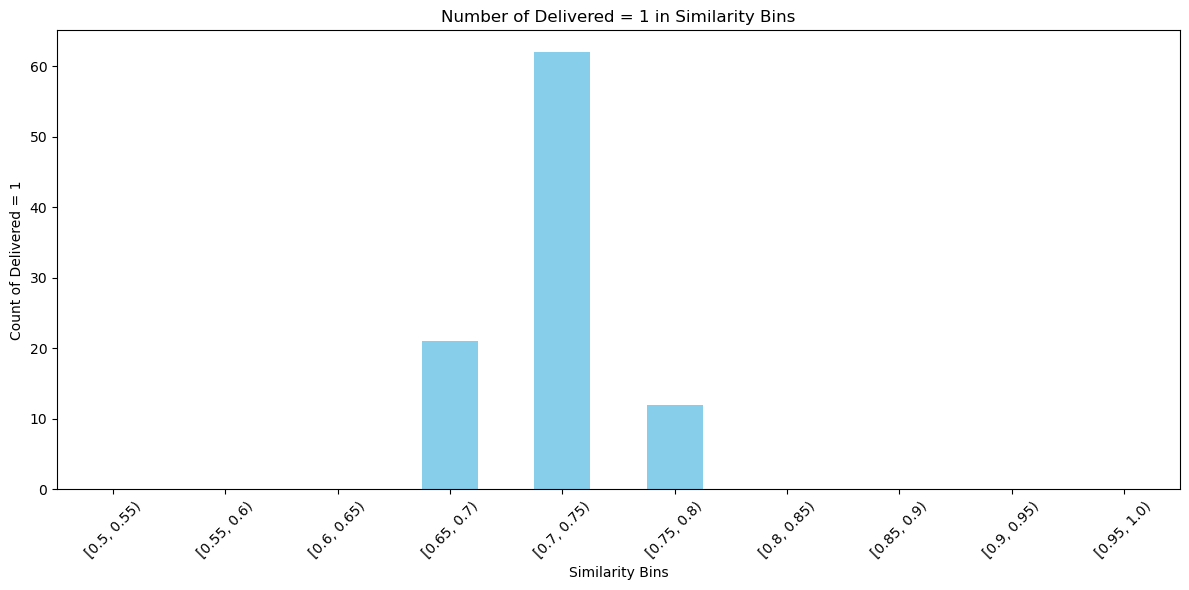

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the dataset
data = pd.read_csv('filtered_actions_with_similarities.csv')

# Define the bin width for similarity
bin_width = 0.05
bins = np.arange(0.5, 1.05, bin_width)

# Create a new column to categorize 'similarity' into bins
data['similarity_bin'] = pd.cut(data['similarity'], bins=bins, right=False)

# Filter the data where 'delivered' equals 1
delivered_1_data = data[data['delivered'] == 1]

# Count the number of occurrences of 'delivered' = 1 in each similarity bin
count_delivered_1 = delivered_1_data.groupby('similarity_bin').size()

# Plot the bar plot
plt.figure(figsize=(12, 6))
count_delivered_1.plot(kind='bar', color='skyblue')
plt.title('Number of Delivered = 1 in Similarity Bins')
plt.xlabel('Similarity Bins')
plt.ylabel('Count of Delivered = 1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
